In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LeakyReLU, LSTM
from tensorflow.keras.optimizers import Adam
from scipy.stats import norm
from scipy.linalg import svd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os 

# Fetch stock data from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Compute technical indicators
def compute_technical_indicators(data):
    data['SMA30'] = data['Close'].rolling(window=30).mean()
    data['SMA100'] = data['Close'].rolling(window=100).mean()
    vol_window = 30
    data['Volatility'] = data['Close'].pct_change().rolling(window=vol_window).std() * np.sqrt(252)
    return data.dropna()

# Black-Scholes option pricing model
def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Apply Black-Scholes model to generate option prices
def add_option_pricing_features(data):
    strike_price = data['Close'] * 1.05
    time_to_maturity = 30 / 252
    risk_free_rate = 0.01
    option_type = 'call'
    data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
    data['Implied_Volatility'] = data['Volatility']
    return data

# Normalize and apply PCA for dimensionality reduction
def preprocess_data(data, n_pca_components=2):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    # pca = PCA(n_components=n_pca_components)
    # data_pca = pca.fit_transform(data_scaled)
    # return np.hstack((data_scaled, data_pca))
    return data_scaled, scaler

# Create sequences for time-series prediction
def create_sequences(data, seq_len, pred_len):
    sequences = []
    for i in range(len(data) - seq_len - pred_len + 1):
        sequences.append(data[i:i + seq_len + pred_len])
    return np.array(sequences)

# Function to create a Hankel matrix
def create_hankel_matrix(time_series, window_size):
    # Create a Hankel matrix where the columns are shifted versions of the time series
    hankel_matrix = np.array([time_series[i:i + window_size] for i in range(len(time_series) - window_size + 1)])
    return hankel_matrix

# Function to perform SVD on the Hankel matrix
def hankel_svd(hankel_matrix):
    # Perform SVD on the Hankel matrix
    U, Sigma, Vt = svd(hankel_matrix, full_matrices=False)
    return U, Sigma, Vt

# Build a neural network model
def build_model(input_shape, output_len):
    model = Sequential([
    LSTM(180, activation='relu', return_sequences=False),  # LSTM layer
    Dense(180),
    LeakyReLU(),
    Dense(360),
    LeakyReLU(),
    Dense(360),
    LeakyReLU(),
    Dense(output_len)  # Output predictions for "Close" prices
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model



def predict_and_plot(m, ticker, data, s, model, seq_len, pred_len, scaler, cut_off):
    plt.figure(figsize=(14, 7))

    rmse_values = []  # To store RMSE values for each section
    section_start_idx = []  # To store the start indices of each 30-day section for placement of RMSE labels
    #s.shape[0]
    for idx in range(0,cut_off+pred_len , pred_len):  # Loop through each 30-day block
    # for idx in range(1): # only first 30 after being trained
        # Input remains in 3D for predictio
        future_input = s[idx, :seq_len, :].reshape(1, seq_len, -1)  # Keep the 3D shape
        future = model.predict(future_input)[0]  # Predict future "Close" prices
        # Pad the prediction with zeros for the "Volume" and "SMA" columns
        future_padded = np.hstack((future.reshape(-1, 1), np.zeros((future.shape[0], data.shape[1] - 3))))  # Adjust for PCA features

        # Inverse transform the padded prediction
        future_transform = scaler.inverse_transform(future_padded)[:, 0]  # Extract "Close"

        # Extract and inverse transform the true "Close" values
        future_true = s[idx, seq_len:, 0].reshape(-1, 1)  # Use only "Close"
        future_true_padded = np.hstack((future_true, np.zeros((future_true.shape[0], data.shape[1] - 3))))  # Adjust for PCA features
        future_true_transform = scaler.inverse_transform(future_true_padded)[:, 0]  # Extract "Close"

        # Calculate RMSE for this 30-day section
        percent_error = np.mean(np.abs((future_true_transform - future_transform) / future_true_transform)) * 100
        rmse_values.append(percent_error)
        section_start_idx.append(idx)  # Store the start index for the percentage error label


        # Plot the predictions
        plt.plot(np.arange(idx, idx + pred_len), future_transform, 
                # label="Train Prediction" if idx < cut_off else "Test Prediction", 
                 color="red" if idx < cut_off else "blue")

        # Plot the true values
        plt.plot(np.arange(idx, idx + pred_len), future_true_transform, 
                 #label="Train True" if idx < cut_off else "Test True", 
                 color="black" if idx < cut_off else "green")

        
    
    # Add legend and grid
    # plt.legend(["Train Prediction", "Train True", "Test Prediction", "Test True"])
    plt.plot([], [], color="red", label="Train Prediction")  # Dummy plot for legend
    plt.plot([], [], color="black", label="Train True")      # Dummy plot for legend
    plt.plot([], [], color="blue", label="Test Prediction")  # Dummy plot for legend
    plt.plot([], [], color="green", label="Test True")      # Dummy plot for legend
    plt.legend()
    for idx in range(0, s.shape[0], pred_len): 
    # Add vertical line to separate each 30-day section
        plt.axvline(x=idx + pred_len, color='gray', linestyle='--', linewidth=1)
    # Title and labels
    
    plt.title(f"{seq_len}-{pred_len} Predictions for {ticker}, model {m}")
    plt.xlabel("Trading Days")
    plt.ylabel("Price")

    # Add RMSE labels below the x-axis at the start of each 30-day section
    for i, rmse in zip(section_start_idx, rmse_values):
        plt.text(i + pred_len / 2, min(plt.ylim()), f"{rmse:.0f}", color="teal", fontsize=10, ha='center', va='top')
    plt.text(- 5- pred_len / 2, min(plt.ylim()), f"MAPE:", color="teal", fontsize=10, ha='center', va='top')
    print(rmse_values)
    plt.grid(True)
    if m == "LSTM w/ 8 features":
        dir = f"{seq_len}-{pred_len}/lstm_8"
        if not os.path.exists(dir):
                os.makedirs(dir)
        plt.savefig(f"{dir}/{ticker}.png")
    return rmse_values[-1] # testing rmse

    # plt.show()

# Call the function


# Main workflow
def main(tickers):
    m = "LSTM w/ 8 features"
    test_rmse = []
    for ticker in tickers:
        # Step 1: Fetch data
        tsla = fetch_stock_data(ticker, start_date="2021-01-01", end_date="2024-09-30")

        # Step 2: Compute indicators
        tsla = compute_technical_indicators(tsla)

        # Step 3: Add Black-Scholes option pricing
        tsla = add_option_pricing_features(tsla)

        # Step 4: Prepare data for training
        features = ['Close', 'Volume', 'SMA30', 'SMA100', 'Volatility', 'Option_Price']
        data = tsla[features].copy()
        # Step 5: Perform Hankel Matrix Decomposition
        window_size = 20  # Size of the sliding window to form the Hankel matrix
        hankel_matrix = create_hankel_matrix(data['Close'].values, window_size)

        # Step 6: Perform SVD on the Hankel matrix
        U, Sigma, Vt = hankel_svd(hankel_matrix)

        # You can choose the first few singular values and modes to add as features
        num_modes = 2  # Number of modes to add as features
        dmd_modes = U[:, :num_modes]  # Select the modes
        dmd_amplitudes = Sigma[:num_modes]  # Select the amplitudes

        # Step 7: Normalize and apply PCA for dimensionality reduction
        processed_data,scaler = preprocess_data(data)

        # Trim the processed_data to match the number of rows in dmd_modes
        processed_data_trimmed = processed_data[-dmd_modes.shape[0]:]  # Trim to match the length of dmd_modes

        # Combine the Hankel decomposition modes with the processed data
        data_combined = np.hstack((processed_data_trimmed, dmd_modes))

        # Step 8: Create sequences for time-series prediction
        seq_len = 6 * 30  # 6 months of data
        pred_len = 20  # Predict the next 20 days
        sequences = create_sequences(data_combined, seq_len, pred_len)

        # Step 9: Split data into training and testing
        cut_off = int(0.95 * sequences.shape[0])
        X_train = sequences[:cut_off, :seq_len, :]
        X_test = sequences[cut_off:, :seq_len, :]
        y_train = sequences[:cut_off, seq_len:, 0]
        y_test = sequences[cut_off:, seq_len:, 0]
        print(sequences.shape)
        
        # Step 10: Build and train the model
        model = build_model(input_shape=(seq_len, X_train.shape[2]), output_len=pred_len)
        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            verbose=1
        )

        test_rmse += [predict_and_plot(m, ticker, data_combined, sequences, model, seq_len, pred_len, scaler, cut_off)]

    mse_for_model  = np.mean(test_rmse)
    return mse_for_model

tickers = ["TSLA","NVDA","AMZN","MSFT", "BIPC", "JNJ","WMB","HMC","MSFT", "TM"]
mse = main(tickers)

[*********************100%***********************]  1 of 1 completed

(623, 200, 8)
Epoch 1/100



/tmp/ipykernel_30474/1339517533.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_30474/1339517533.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 0.0882
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0180
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0122
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0095
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0082
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0078
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0066
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0074
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0060
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0053
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0047
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0040
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0033
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0029
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.00

[*********************100%***********************]  1 of 1 completed

(623, 200, 8)
Epoch 1/100



/tmp/ipykernel_30474/1339517533.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_30474/1339517533.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.0702
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0065
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0048
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.0029
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0027
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0021
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0024
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0019
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0014
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0015
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0011
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0012
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.8404e-04
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 9.0468e-04
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - lo

[*********************100%***********************]  1 of 1 completed

(623, 200, 8)
Epoch 1/100



/tmp/ipykernel_30474/1339517533.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_30474/1339517533.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.1341
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0115
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0084
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0084
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0070
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0066
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0080
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0053
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0058
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0051
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0044
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0043
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0038
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0030
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0026


[*********************100%***********************]  1 of 1 completed

(623, 200, 8)
Epoch 1/100



/tmp/ipykernel_30474/1339517533.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_30474/1339517533.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.1274
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0085
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0046
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0037
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0034
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0036
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0034
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0033
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0035
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0034
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0030
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0030
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0031
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0030
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0027
E

[*********************100%***********************]  1 of 1 completed

(623, 200, 8)
Epoch 1/100



/tmp/ipykernel_30474/1339517533.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_30474/1339517533.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.1752
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0182
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0125
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0097
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0094
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0084
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0079
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0077
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0068
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0068
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0058
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0051
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0050
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0056
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0047
E

[*********************100%***********************]  1 of 1 completed

(623, 200, 8)
Epoch 1/100



/tmp/ipykernel_30474/1339517533.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_30474/1339517533.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.1401
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0254
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0163
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0153
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0123
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0142
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0121
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0123
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0123
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0096
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0089
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0079
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0072
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0073
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0062
E

[*********************100%***********************]  1 of 1 completed

(623, 200, 8)
Epoch 1/100



/tmp/ipykernel_30474/1339517533.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_30474/1339517533.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.1142
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0083
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0062
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0059
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0043
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0037
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0042
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0039
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0029
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0028
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0024
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0023
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0024
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0019
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0018
E

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HMC']: ConnectionError(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')))


ValueError: attempt to get argmax of an empty sequence

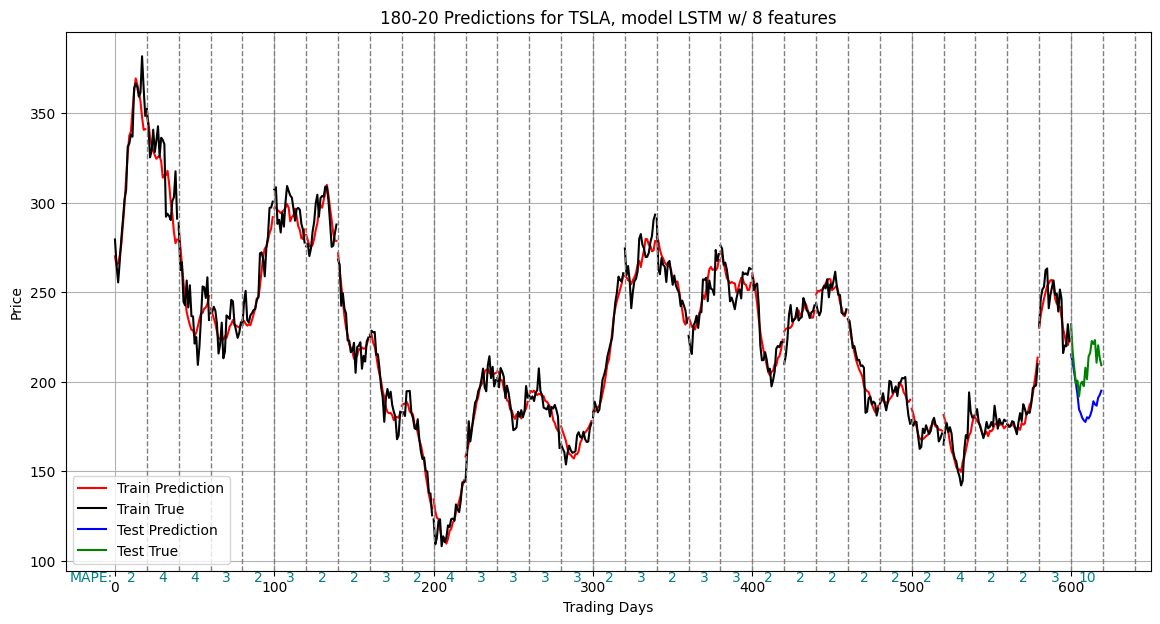

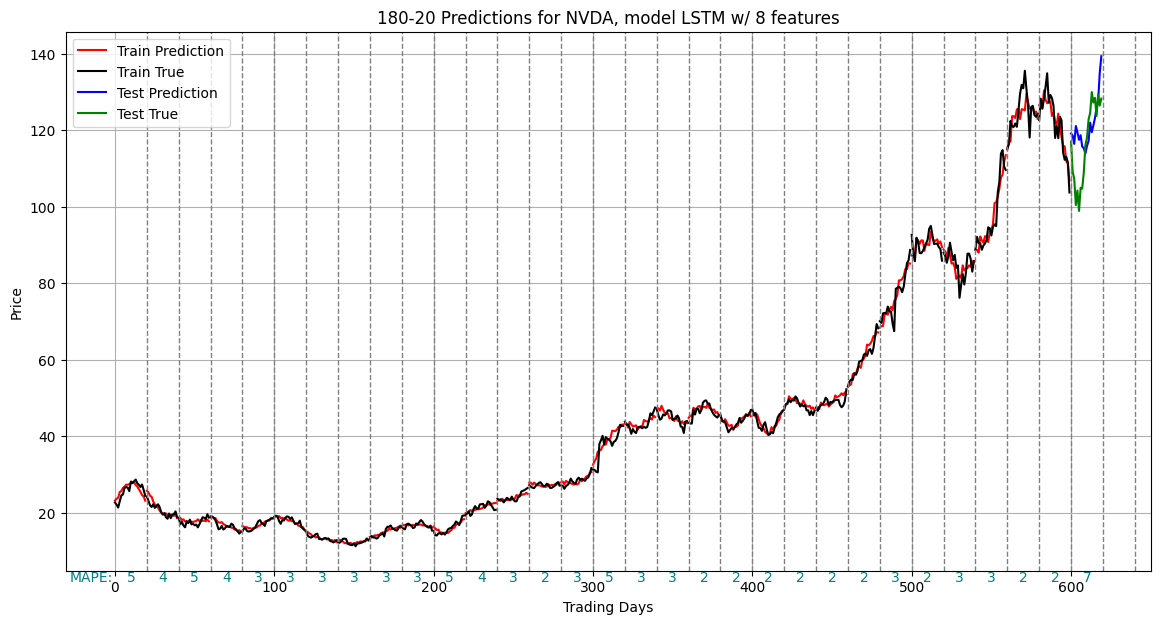

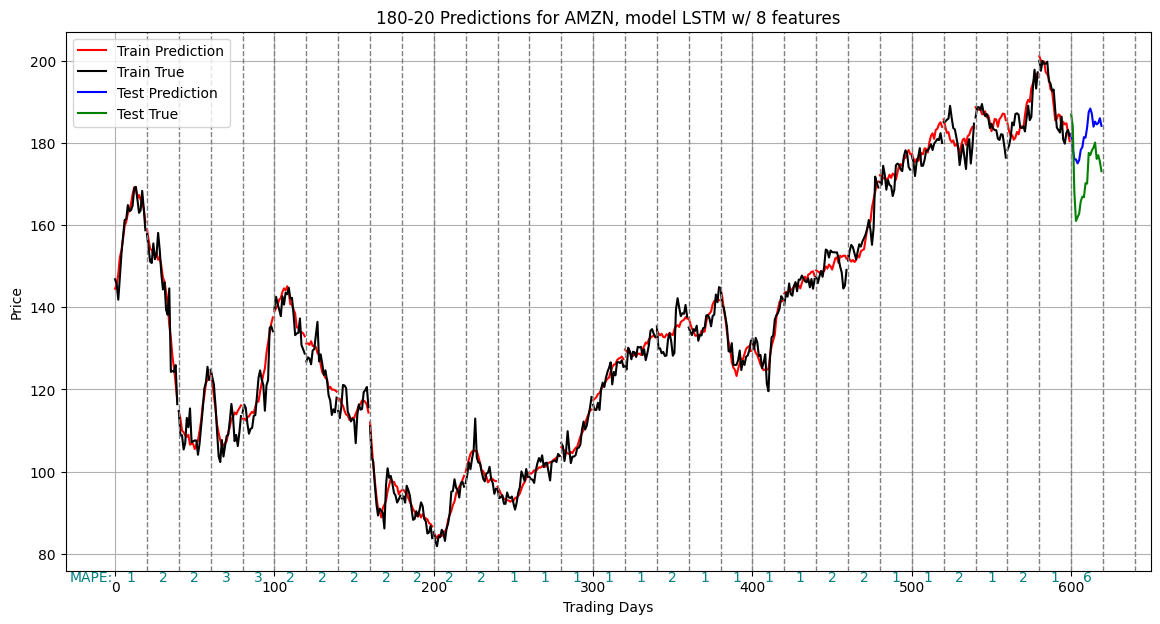

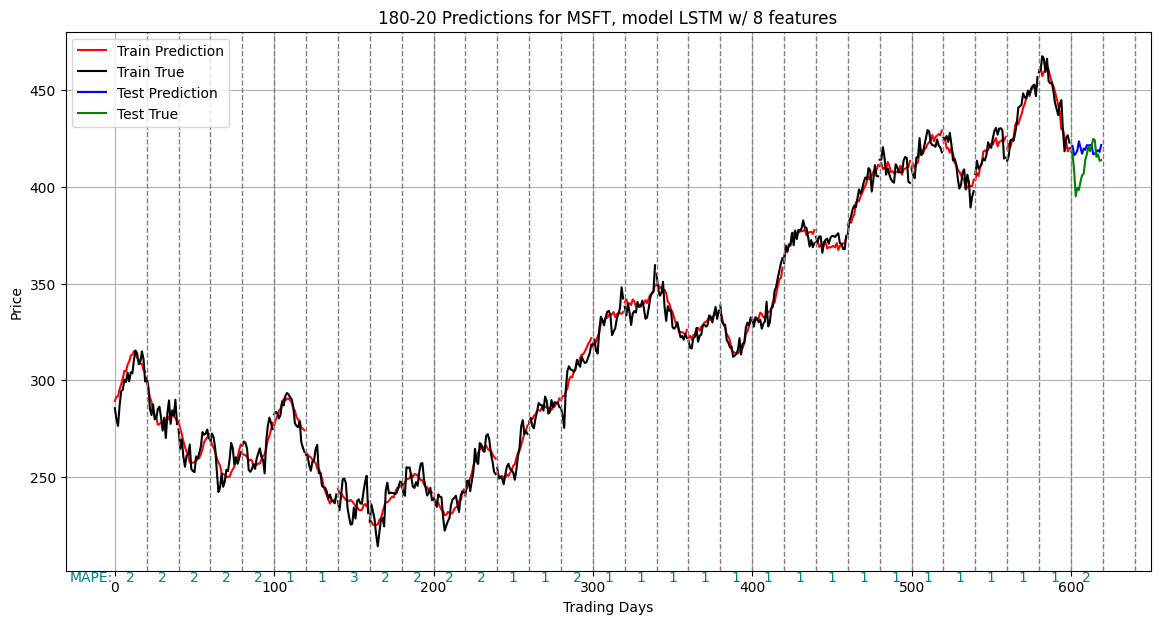

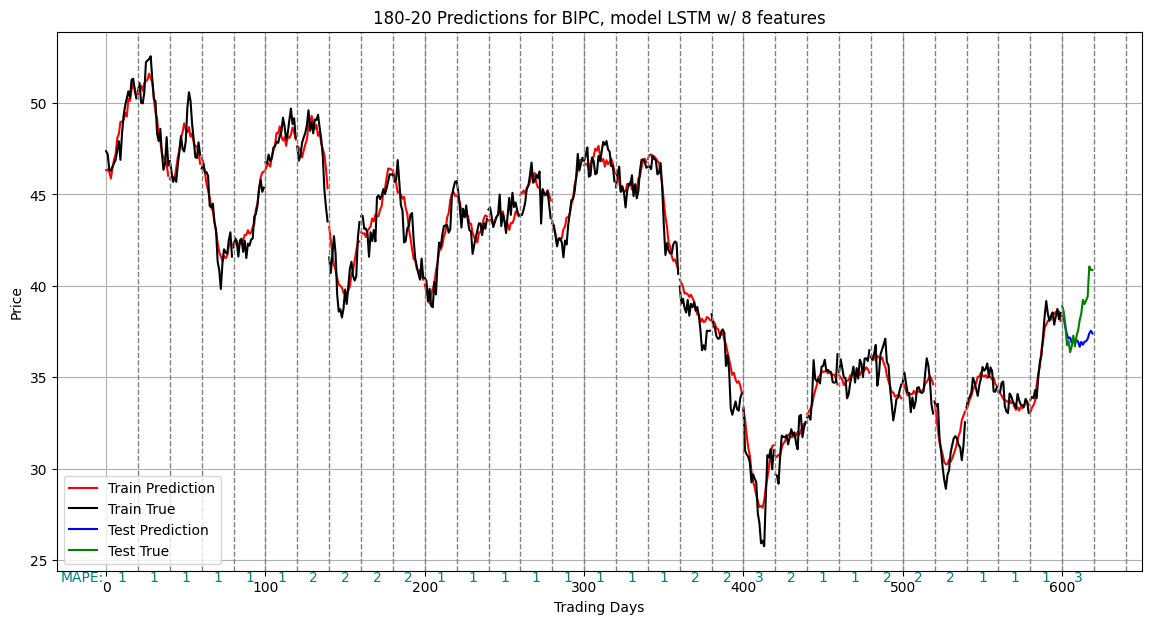

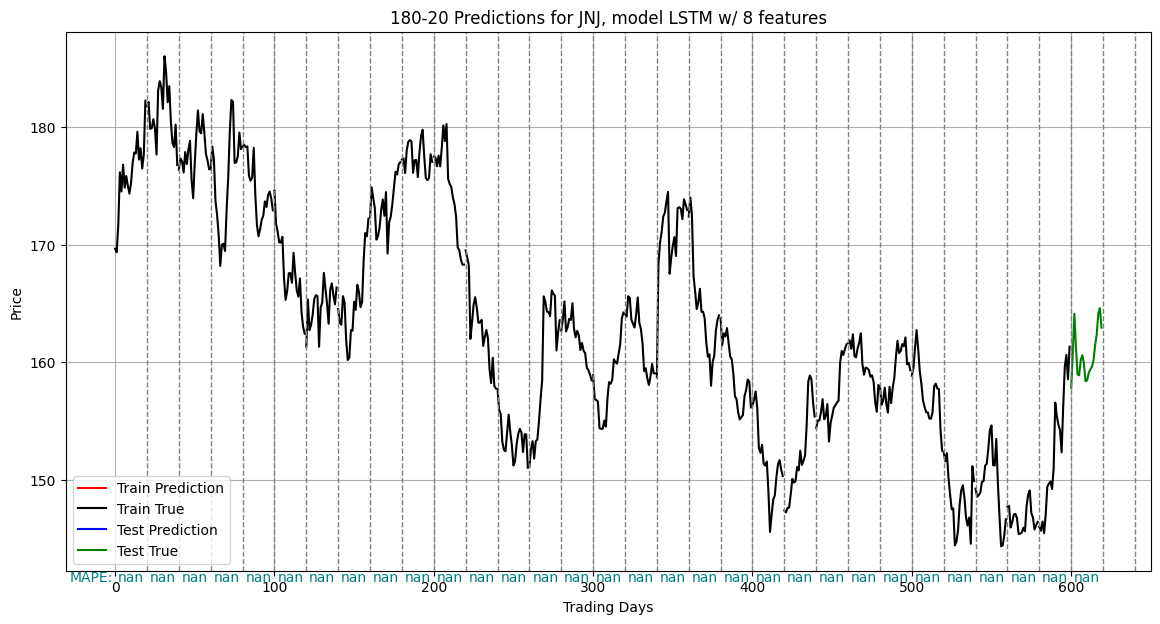

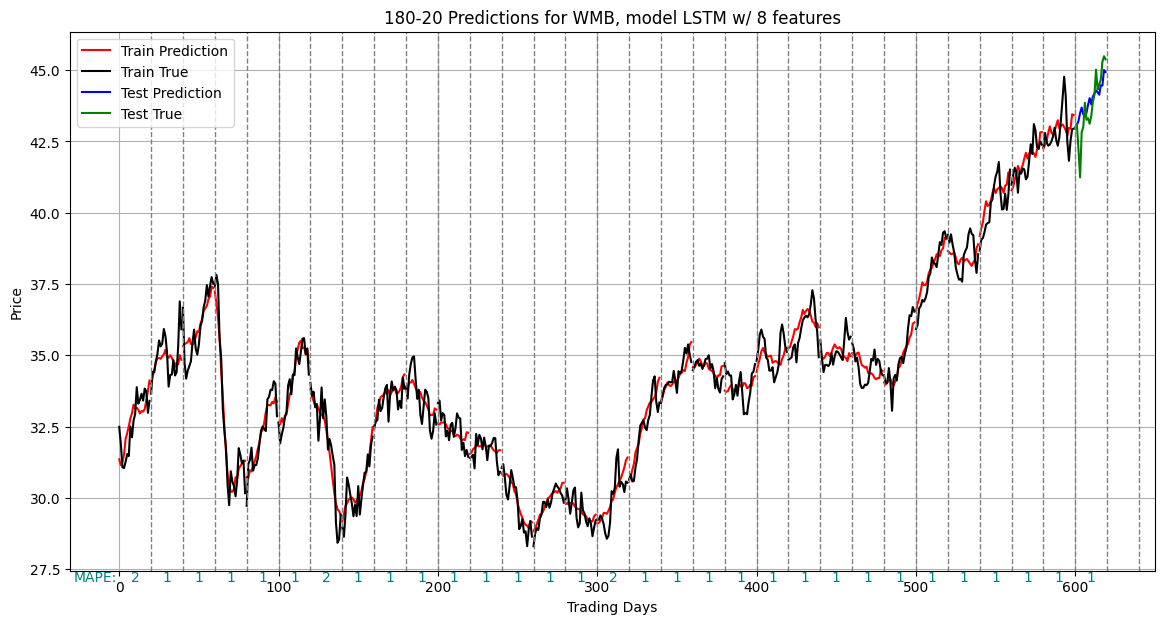

: 

In [ ]:
tickers = ["TSLA","NVDA","AMZN","MSFT", "BIPC", "JNJ","WMB","HMC","MSFT", "TM"]
mse = main(tickers)

In [ ]:
mse

NameError: name 'mse' is not defined